# 7.7 Stochastic and Mini-Batch Learning

- As described in [Section 3.11](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_11_Minibatch.html), stochastic and mini-batch learning can drastically accelerate (particularly first order) local optimization algorithms. 


- Having completed our description of *linear* supervised learning techniques - that is regression, two-class, and multi-class classification.


- In this Section we look back and provide a new *online learning* perspective of the stochastic / mini-batch learning approaches.

You can toggle the code on and off in this presentation via the button below.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# This code cell will not be shown in the HTML version of this notebook
# import custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
datapath = '../../mlrefined_datasets/superlearn_datasets/'

# demos for this notebook
regress_plotter = superlearn.lin_regression_demos
optimizers = optlib.optimizers
static_plotter = optlib.static_plotter.Visualizer();

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## The stochastic gradient descent

- In [Section 3.11](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_11_Minibatch.html) we discussed the concept of mini-batch optimization.


- This simple trick tends to drastically accelerate the minimization of cost functions that consist of $P$ terms of the form 

\begin{equation}
g\left(\mathbf{w}\right) = \sum_{p=1}^P g_p\left(\mathbf{w}\right)
\end{equation}



- Here $g_1\,g_2,\,...,g_P$ are all functions of the same kind. 


- Looking backwards, in this Chapter as well as the two that proceeded it, absolutely *every cost function took this form*.  


- That is, every machine learning cost function for regression, two-class, and multi-class classification takes the general form above.


- Thus we can think about applying mini-batch optimization in tuning their parameters (this trend will continue as we move forward as well, e.g., when discussing the *autoencoder* in [Section 8.4](https://jermwatt.github.io/machine_learning_refined/notes/8_Linear_unsupervised_learning/8_4_Autoencoder.html)).  

- For example, the Multiclass Softmax cost introduced in [Section 7.3.5](https://jermwatt.github.io/machine_learning_refined/notes/7_Linear_multiclass_classification/7_3_Perceptron.html)

\begin{equation}
g\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) = \frac{1}{P}\sum_{p = 1}^P \left[\text{log}\left( \sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}}  \right) - \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}\right].
\end{equation}

- takes this general form where

\begin{equation}
g_p\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) =\text{log}\left( \sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}}  \right) - \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}.
\end{equation}

- In other words, *machine learning cost functions de-compose over their training data* where the summand $g_p$ measures the error of the cost on the $p^{th}$ training point.  


- Now, since machine learning cost summands are inherently tied to training datapoints, in the context of machine learning we can think about mini-batch optimization *equivalently in terms of mini-batches of training data* as well.  


- Thus as opposed to a standard (also called full batch) local optimization technique that takes individual steps by sweeping through an *entire* set of training data *simultaneously*, the mini-batch approach has us take smaller steps sweeping through training data *sequentially*.


- One complete sweep through the data being referred to as an *epoch* of mini-batch learning.  


- This machine learning / data driven interpretation is illustrated schematically in the Figure below.

<img src= '../../mlrefined_images/superlearn_images/ml_stochastic.png' width="100%" height="auto"/>


- As with generic cost functions, mini-batch learning often greatly accelerates the minimization of machine learning cost functions (and thus the corresponding learning taking place).  


- This is particularly true when dealing with *very large datasets*, i.e., when $P$ is large.    


- With very large datasets the mini-batch approach can also help limit the amount of active memory consumed in storing data by loading in - at each step in a mini-batch epoch - *only the data included in the current mini-batch*.   

- The mini-batch approach can also be used (or interpreted) as a so-called *online learning* technique, wherein data actually *arises* in small mini-batches and is directly used to update the parameters of the associated model.  

#### <span style="color:#a50e3e;">Example. </span>  Comparing standard to minibatch gradient descent 

- Recognizing handwritten digits is a popular multiclass classification problem commonly built into the software of mobile banking applications, as well as more traditional Automated Teller Machines, to give users.


- e.g., the ability to automatically deposit paper checks. Here each class of data consists of (images of) several handwritten version of a single digit in the range $0-9$, giving a total of $10$ classes.  

<img src= '../../mlrefined_images/superlearn_images/MNIST_examples.png' width="45%" height="auto"/>

- In the figure below we illustrate the acclerated convergence of mini-batch gradient descent an the Softmax cost over the standard method using $P = 50,000$ random training points from the MNIST dataset.

- This is a popoular collection of handwritten images like those shown in the figure above.


- In particular we show a comparison of the first $10$ steps / epochs of both methods, using a batch of size $200$ for the mini-batch size and the same steplength for both runs

In [3]:
# This code cell will not be shown in the HTML version of this notebook
# load data
from sklearn.datasets import fetch_mldata
MNIST = fetch_mldata('MNIST original')
x = MNIST.data.astype('float64').T
y = np.reshape(MNIST.target, (-1, 1)).T
num_pts = np.size(y)

# subsample
num_samples = 50000
inds = np.random.permutation(num_pts)[:num_samples]
x_sample = x[:,inds]
y_sample = y[:,inds]

<IPython.core.display.Javascript object>


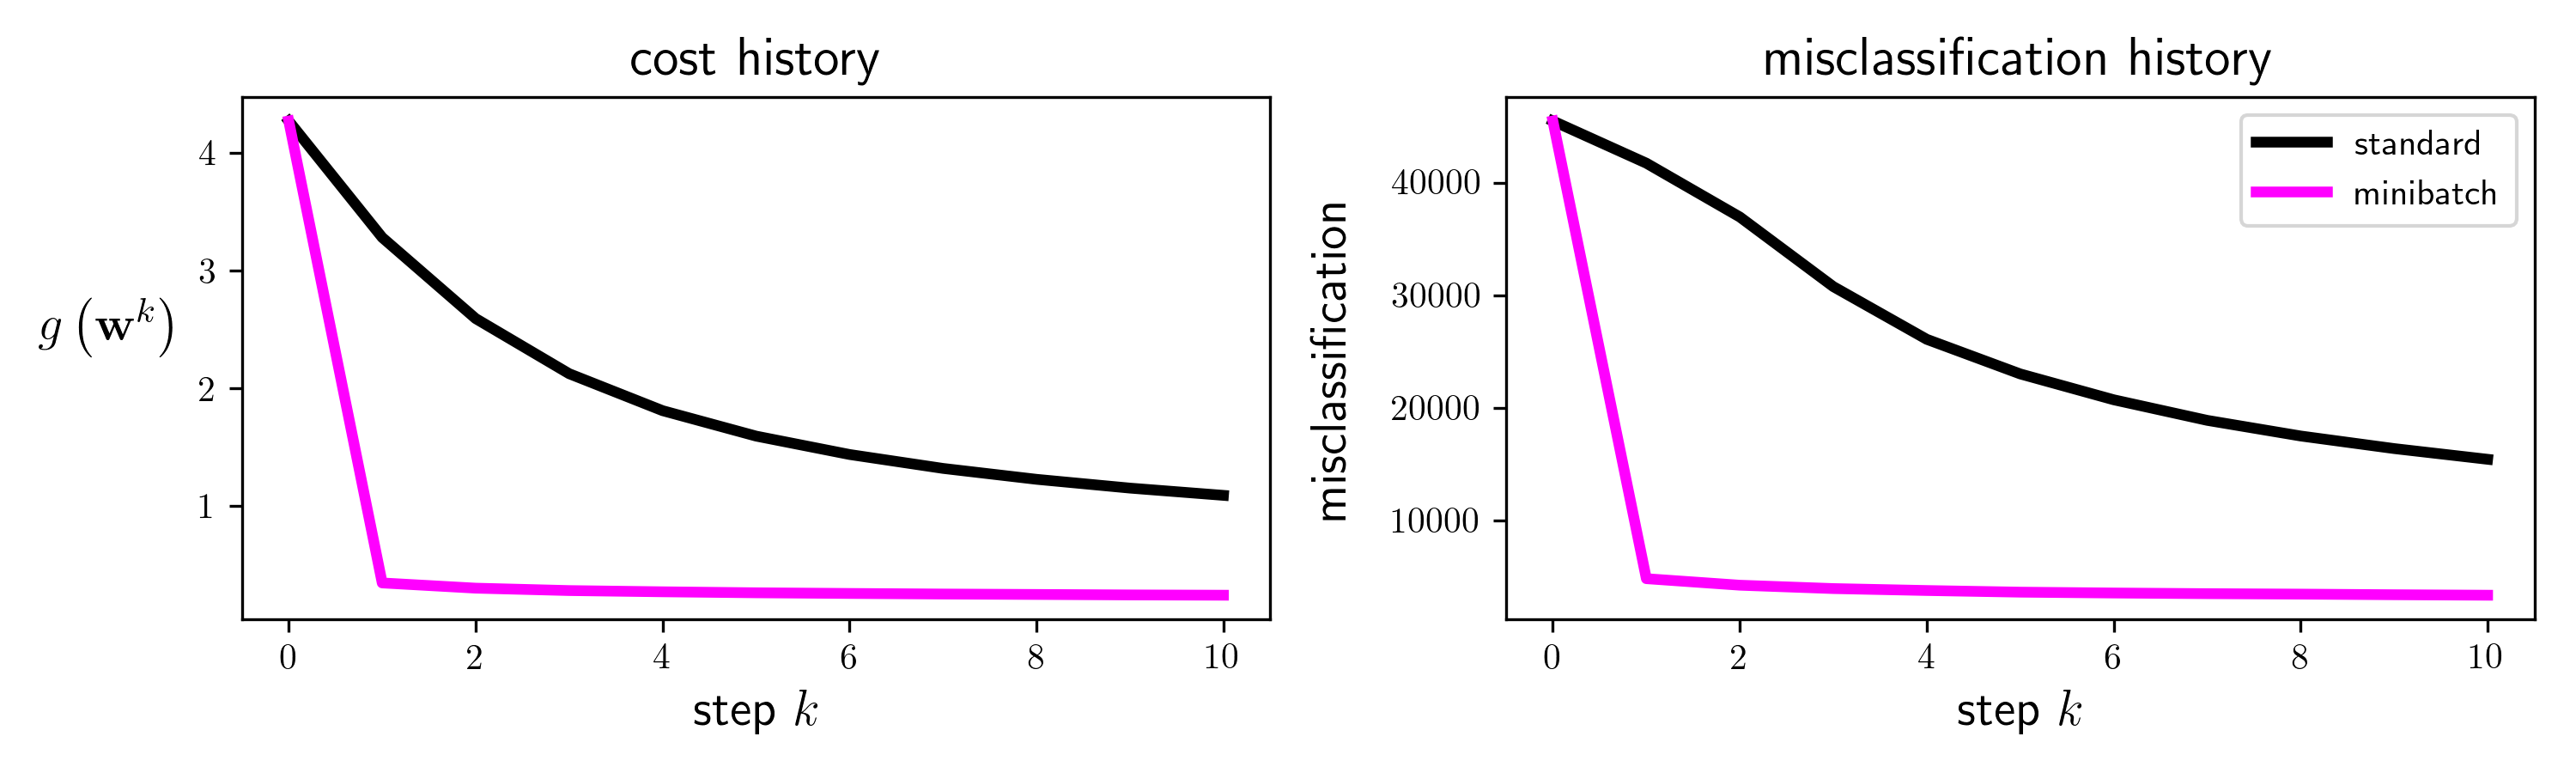

In [4]:
## This code cell will not be shown in the HTML version of this notebook
# import the v1 library
mylib0 = nonlib.mlp_complib.superlearn_setup.Setup(x_sample,y_sample)

# choose features
layer_sizes = [784,10]

# choose features
mylib0.choose_features(name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'linear')

# choose normalizer
mylib0.choose_normalizer(name = 'standard')

# choose cost
mylib0.choose_cost(name = 'multiclass_softmax')

# fit an optimization
alpha = 10**(-1)
mylib0.fit(max_its = 10,alpha_choice = alpha)
mylib0.fit(max_its = 10,alpha_choice = alpha,batch_size = 200,w_init = mylib0.w_init)

# show histories
labels = ['standard','minibatch']
mylib0.show_histories(labels = labels)

- Here we see that the mini-batch run drastically accelerates minimization in terms of both the cost function (left panel) and number of misclassifications (right panel). 